In [1]:
import yfinance as yf
import pandas as pd
import numpy as np 

#### 3.1 Form dollar bars for E-mini S&P 500 futures:  

In [46]:
min_df=pd.read_csv('./GSPC.INDX_1m.csv', index_col=0, parse_dates=True)
min_df=min_df[min_df.index>pd.Timestamp('2024-06-01')]

In [56]:
def get_dollar_bars(df:pd.DataFrame, dollar_threshold:float=1000000):
    dollar=df['Volume']*df['Close']
    dollar_sum=0
    start_idx=0;
    dollar_bars=pd.DataFrame(columns=["Open", "High", "Close", "Low", "Volume"])
    for i in range(len(df)):
        dollar_sum+=dollar.iloc[i]
        if dollar_sum>=dollar_threshold:
            bar={
                "Open": df.iloc[start_idx]['Open'],
                "High": df.iloc[start_idx:i+1]['High'].max(),
                "Close": df.iloc[i]['Close'],
                "Low": df.iloc[start_idx:i+1]['Low'].min(),
                "Volume": df.iloc[start_idx:i+1]['Volume'].sum(),
            }
            if dollar_bars.empty:
                dollar_bars=pd.DataFrame(bar, index=[df.index[i]])
            else:
                dollar_bars=pd.concat([dollar_bars, pd.DataFrame(bar, index=[df.index[i]])])
            start_idx=i+1
            dollar_sum=0
    if dollar_sum!=0:
        bar={
            "Open": df.iloc[start_idx]['Open'],
            "High": df.iloc[start_idx:]['High'].max(),
            "Close": df.iloc[-1]['Close'],
            "Low": df.iloc[start_idx:]['Low'].min(),
            "Volume": df.iloc[start_idx:]['Volume'].sum(),
        }
        dollar_bars=pd.concat([dollar_bars, pd.DataFrame(bar, index=[df.index[i]])])
    return dollar_bars 

dollar_bars=get_dollar_bars(min_df, dollar_threshold=100000000000)
dollar_bars_returns=dollar_bars['Close'].pct_change().dropna()
print(dollar_bars)

                           Open        High       Close         Low  \
2024-06-03 13:32:00  5297.14990  5300.12988  5296.45996  5295.35010   
2024-06-03 13:34:00  5296.29004  5296.77979  5295.72998  5294.93018   
2024-06-03 13:36:00  5295.52002  5297.27979  5296.39990  5294.45996   
2024-06-03 13:39:00  5296.33008  5296.81006  5296.58984  5294.58984   
2024-06-03 13:42:00  5296.58984  5298.77002  5298.70020  5295.50000   
...                         ...         ...         ...         ...   
2024-09-30 15:55:00  5756.52979  5761.39014  5760.20996  5756.52979   
2024-09-30 15:56:00  5760.41992  5762.79980  5762.37988  5760.16992   
2024-09-30 15:57:00  5762.14014  5765.14014  5765.04004  5760.87012   
2024-09-30 15:58:00  5765.00000  5765.04004  5762.62012  5761.52979   
2024-09-30 15:59:00  5762.29004  5764.12012  5760.91992  5757.72021   

                         Volume  
2024-06-03 13:32:00  20749331.0  
2024-06-03 13:34:00  19365425.0  
2024-06-03 13:36:00  20688210.0  
2024-06-03 

Simple IID Test

In [57]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller

# independence test
id_df=acorr_ljungbox(dollar_bars_returns, lags=[10], return_df=True)
print('p-value:', id_df['lb_pvalue'].iloc[0], 'p-value_test', id_df['lb_pvalue'].iloc[0]>0.05)

# identical distribution test
adf_df=adfuller(dollar_bars_returns, autolag="AIC")
print('p-value:', adf_df[1], 'p-value_test', adf_df[1]<0.05)

# heteroskedasticity test
from statsmodels.stats.diagnostic import het_arch
het_df=het_arch(dollar_bars_returns)
print('p-value:', het_df[1], 'p-value_test', het_df[1]>0.05)



p-value: 0.05728011449770432 p-value_test True
p-value: 0.0 p-value_test True
p-value: 0.9998499572443289 p-value_test True


(a) Apply a symmetric CUMSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).

In [58]:
daily_df=yf.download("^GSPC",multi_level_index=False)

[*********************100%***********************]  1 of 1 completed


2024-06-04 13:36:00    0.000266
2024-06-04 13:40:00    0.000416
2024-06-04 13:44:00    0.000381
2024-06-04 13:48:00    0.000406
2024-06-04 13:52:00    0.000781
                         ...   
2024-09-30 15:55:00    0.002340
2024-09-30 15:56:00    0.002424
2024-09-30 15:57:00    0.002518
2024-09-30 15:58:00    0.002599
2024-09-30 15:59:00    0.002669
Name: Close, Length: 7513, dtype: float64


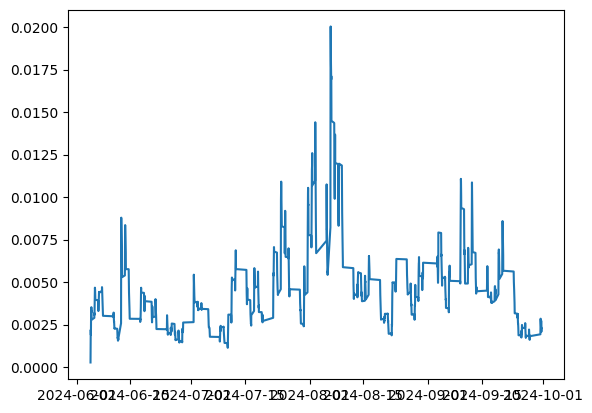

In [ ]:
def get_daily_volatility(df:pd.DataFrame, span:int=100):
    daily_index=pd.DatetimeIndex(sorted({pd.Timestamp(t.date()) for t in df['Close'].index}))
    def get_before_date(t:pd.Timestamp):
        date_to_daily=pd.Timestamp(t.date())
        before_day=daily_index[daily_index<date_to_daily]
        if len(before_day)==0:
            return t-pd.Timedelta(days=1)
        date_diff=date_to_daily-before_day[-1]
        return t-date_diff
    
    ret=df['Close'].index.searchsorted([get_before_date(t) for t in df['Close'].index])
    ret=ret[ret>0]
    ret=pd.Series(df['Close'].index[ret],index=df['Close'].index[-len(ret):])
    daily_ret=df['Close'].loc[ret.index]/df['Close'].loc[ret.values].values-1
    daily_vol=daily_ret.ewm(span=span).std()   
    return daily_vol.dropna()

daily_volatility=get_daily_volatility(dollar_bars, span=100)

In [60]:
def get_cumsum_filter(bar_df:pd.DataFrame, daily_volatility:pd.Series):
   diff=bar_df['Close'].pct_change().dropna().diff().dropna()
   intersect_idx=diff.index.intersection(daily_volatility.index)
   # index 통일
   bar_df=bar_df.loc[intersect_idx]
   diff=diff.loc[intersect_idx]
   daily_volatility=daily_volatility.loc[intersect_idx]
   
   s_pos, s_neg=0, 0
   start_idx=0
   cumsum_bar=pd.DataFrame(columns=["Open", "High", "Close", "Low", "Volume"])
   for i in range(len(diff)):
      s_pos=max(0, s_pos+diff.iloc[i]) # IID에 가깝기 때문에 E_{t-1}[y_t]~=y_{t-1}
      s_neg=min(0, s_neg+diff.iloc[i])
      s=max(s_pos, -s_neg)
      if s>daily_volatility.iloc[i]:
         sub_df=bar_df.iloc[start_idx:i+1]
         bar = {
            "Open": sub_df.iloc[0]['Open'],
            "High": sub_df['High'].max(),
            "Close": sub_df.iloc[-1]['Close'],
            "Low": sub_df['Low'].min(),
            "Volume": sub_df['Volume'].sum(),
         }
         if cumsum_bar.empty:
            cumsum_bar=pd.DataFrame(bar, index=[diff.index[i]])
         else:
            cumsum_bar=pd.concat([cumsum_bar, pd.DataFrame(bar, index=[diff.index[i]])])
         start_idx=i+1
         s_pos, s_neg=0, 0
   return cumsum_bar

cumsum_bar=get_cumsum_filter(dollar_bars, daily_volatility)

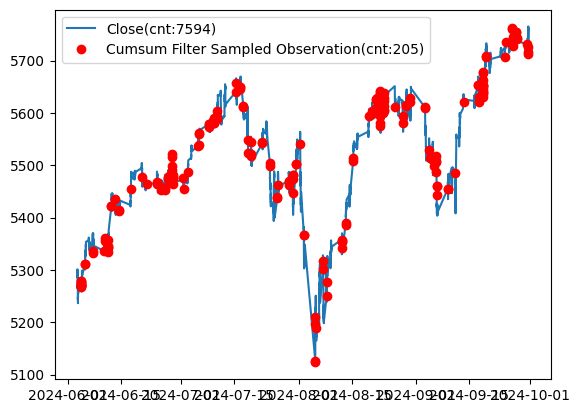

In [61]:
import matplotlib.pyplot as plt

plt.plot(dollar_bars["Close"], label=f'Close(cnt:{len(dollar_bars)})')
plt.plot(cumsum_bar["Close"], label=f'Cumsum Filter Sampled Observation(cnt:{len(cumsum_bar)})', marker='o', color='r', linestyle='')
plt.legend()
plt.show()

(b)Use Snippet 3.4 on a pandas series t1, where numDays = 1.

In [62]:
def apply_triple_barrier_method(close:pd.Series, events:pd.DataFrame, barrier_width:tuple):
    '''
    Apply the triple barrier method to a series of events.

    :param close: pd.Series The close price series.
    events : pd.DataFrame
        The events dataframe containing the event times and labels. (t1: vertical barrier, trgt: unit width of horizontal barriers)
    barrier_width : tuple
        A tuple containing the upper and lower barrier widths.
    :return: pd.DataFrame
        A dataframe with the event times and the corresponding profit taking and stop loss times. (t1: vertical barrier, pt: profit taking, sl: stop loss)
    '''
    ret=events[['t1']].copy(deep=True)
    upper_barrier_width, lower_barrier_width=barrier_width
    if upper_barrier_width>0:
        profit_taking=events['trgt']*upper_barrier_width
    else:
        profit_taking=pd.Series(index=events.index, data=[np.nan]*len(events))
    if lower_barrier_width>0:
        stop_loss=-events['trgt']*lower_barrier_width
    else:
        stop_loss=pd.Series(index=events.index, data=[np.nan]*len(events))
    for loc, t1 in events['t1'].fillna(close.index[-1]).items():
        path_price=close.loc[loc:t1]
        if len(path_price)==0:
            ret.loc[loc, 'sl']=np.nan
            ret.loc[loc, 'pt']=np.nan
            continue
        path_return=(path_price/path_price.iloc[0]-1).dropna()
        ret.loc[loc, 'sl']=path_return[path_return<stop_loss[loc]].index.min()
        ret.loc[loc, 'pt']=path_return[path_return>profit_taking[loc]].index.min()
    return ret


In [63]:
def get_events(close:pd.Series, t_events:pd.DatetimeIndex, barrier_width:tuple, target:pd.Series, min_ret:float, num_threds, t1:pd.Series=None):
    '''
    Find the time of the first barrier touch

    :param close: pd.Series The close price series.
    t_events: pd.DatetimeIndex 
        timestamps that will seed every triple barrier
    barrier_width: tuple
        A tuple containing the upper and lower barrier widths.
    target: pd.Series
        The target absolute return
    min_ret: float
        The minimum return to consider a trade.
    num_threds: int
        The number of threads to use for parallel processing.
    t1: pd.Series
        The vertical barrier time series.
    '''
    # Get the events
    target=target.loc[t_events]
    target=target[target>min_ret]

    # Get t1
    if t1 is None:
        t1=pd.Series(pd.NaT, index=t_events)
    
    # Form events object, apply stop loss on t1
    side_=pd.Series(1., index=target.index)
    events=pd.concat({'t1': t1, 'trgt': target, 'side': side_}, axis=1).dropna(subset=['trgt'])

    triple_barrier=apply_triple_barrier_method(close, events, barrier_width)
    events['t1']=triple_barrier.dropna(how='all').min(axis=1)
    events=events.drop('side', axis=1)  
    return events


# Example Vertical Barrier
num_days=1
t1=dollar_bars.index.searchsorted(cumsum_bar.index+pd.Timedelta(days=num_days))
t1=t1[t1<len(dollar_bars.index)]
t1=pd.Series(data=dollar_bars['Close'].index[t1], index=cumsum_bar.index[:len(t1)])

(c) On those sampled features, apply the triple-barrier method, where
ptSl=[1,1]and t1 is the series you created inpoint 1.b.

In [64]:

# target의 경우 미래 구간에서 발생될 기대하는 수익률의 예시를 넣음
events=get_events(dollar_bars['Close'], cumsum_bar.index, (1, 1), (dollar_bars['Close'] / dollar_bars['Close'].shift(1) - 1).abs().rolling(50).mean(),  0.0, 1, t1)

(d) Apply getBins to generate the labels

In [65]:
def get_bins(events:pd.DataFrame, close:pd.Series):
    '''
    Get the bins for the events.
    
    :param events: pd.DataFrame The events dataframe containing the event times and labels.
    close: pd.Series The close price series.
    :return: pd.DataFrame
        A dataframe with the event times and the corresponding bins.
    '''
    events_=events.dropna(subset=['t1'])
    price=events_.index.union(events_['t1'].values).drop_duplicates()
    price=close.reindex(price, method='bfill')
    ret=pd.DataFrame(index=events_.index)
    ret['ret']=price.loc[events_['t1']].values/price.loc[events_.index].values-1
    ret['bin']=np.sign(ret['ret'])
    return ret

bins=get_bins(events, dollar_bars['Close'])
print(bins['bin'].value_counts())

bin
 1.0    109
-1.0     96
Name: count, dtype: int64


#### 3.2 From exercise 1, use Snippet 3.8 to drop rare labels.

In [66]:
def drop_labels(events:pd.DataFrame, min_pct:float):
    '''
    Drop labels with a percentage of less than min_pct
    '''
    while True:
        df0=events['bin'].value_counts(normalize=True)
        if df0.min()>min_pct or df0.shape[0]<3: break
        print('drop labels:', df0.argmin(), df0.min())
        events=events[events['bin']!=df0.argmin()]
    return events
bins=drop_labels(bins, 0.05)
print(bins['bin'].value_counts())

bin
 1.0    109
-1.0     96
Name: count, dtype: int64


#### 3.3 Adjust the getBins function (Snippet 3.5) to return a 0 whenever the vertical barrier is the one touched first.

In [67]:
def get_bins(events:pd.DataFrame, close:pd.Series, t1:pd.Series):
    '''
    Get the bins for the events.
    
    :param events: pd.DataFrame The events dataframe containing the event times and labels.
    close: pd.Series The close price series.
    t1: pd.Series 
        The vertical barrier time series.
    :return: pd.DataFrame
        A dataframe with the event times and the corresponding bins.
    '''
    # check vertical barrier touch first
    vt_time_stamp=pd.DatetimeIndex([])
    for loc, torch_time in events['t1'].items():
        if (loc in t1.index) and t1.loc[loc]==torch_time:
            vt_time_stamp=vt_time_stamp.append(pd.DatetimeIndex([loc]))
            
    events_=events.dropna(subset=['t1'])
    price=events_.index.union(events_['t1'].values).drop_duplicates()
    price=close.reindex(price, method='bfill')
    ret=pd.DataFrame(index=events_.index)
    ret['ret']=price.loc[events_['t1']].values/price.loc[events_.index].values-1
    ret['bin']=np.sign(ret['ret'])
    ret.loc[vt_time_stamp, 'bin']=0
    return ret

bins=get_bins(events, dollar_bars['Close'], t1)

#### 3.4 Develop a trend-following strategy based on a popular technical analysis statistic (e.g.,crossing moving averages).For each observation,the model suggests a side, but not a size of the bet.

(a) Derive meta-labels for ptSl=[1,2] and t1 where numDays=1. Use as trgt the daily standard deviation as computed by Snippet 3.1

In [117]:
def bolinger_band(df:pd.DataFrame, window:int=20, num_std:int=2):
    '''
    Bolinger band cross over strategy
    :param df: pd.DataFrame The dataframe containing the close price series.
    window: int
        The window size for the moving average.
    num_std: int
        The number of standard deviations for the bolinger band.
    :return: pd.DataFrame
        A dataframe with the event times and the corresponding bins.
    '''
    #1. 박스권 장세인 경우
    df['MA']=df['Close'].rolling(window).mean()
    df['STD']=df['Close'].rolling(window).std()
    df['UPPER']=df['MA']+num_std*df['STD']
    df['LOWER']=df['MA']-num_std*df['STD']
    # 밴드 폭이 좁고, 가격이 중심선에 위치
    # 고저 범위
    range_thresh = 0.005  # 0.5% 이내면 박스권으로 간주
    df['high_low_range'] = df['High'].rolling(window).max() - df['Low'].rolling(window).min()
    df['hl_pct'] = df['high_low_range'] / df['Lower']

    # 종가 방향성 (거의 변화 없을 때: 표준편차 낮음)
    df['close_std'] = df['Close'].rolling(window).std()

    # 박스권 조건
    df['is_box'] = (
        (df['STD'] < df['STD'].rolling(window).mean() * 0.7) &
        (df['hl_pct'] < range_thresh) &
        (df['close_std'] < df['close_std'].rolling(window).mean() * 0.7)
    )
    #buy_signal=(df['Close']>df['Lower']) & (df['Close'].shift(1)<=df['Lower'].shift(1))
    #sell_signal=(df['Close']<df['Upper']) & (df['Close'].shift(1)>=df['Upper'].shift(1)) 
    return df

def get_rsi(df:pd.DataFrame, period:int=14):
    '''
    Get the RSI for the given dataframe.
    
    :param df: pd.DataFrame The dataframe containing the close price series.
    period: int
        The period for the RSI calculation.
    :return: pd.DataFrame
        A dataframe with the event times and the corresponding bins.
    '''
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi



In [118]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

class SignalStrategy(Strategy):
    def init(self):
        pass

    def next(self):
        signal=self.data.Side[-1]
        is_box=self.data.is_box[-1]
        rsi=self.data.rsi[-1]
        if is_box: # 박스권 장세인 경우
            if signal == 1:
                if self.position.is_short:
                    self.position.close()
                if not self.position:
                    self.buy(size=1)

            elif signal == -1:
                if self.position.is_long:
                    self.position.close()
                if not self.position:
                    self.sell(size=1)  # 이때는 short 포지션
        else: # 추세 추종
            if rsi> 70 :
                if self.position.is_short:
                    self.position.close()
                if not self.position:
                    self.buy()
            elif rsi< 30 and signal == -1:
                if self.position.is_long:
                    self.position.close()
                if not self.position:
                    self.sell()
            
            

ret=bolinger_band(dollar_bars.copy(deep=True), window=20, num_std=2)
rsi=get_rsi(dollar_bars.copy(deep=True), period=14)
data=dollar_bars.copy(deep=True)
data['is_box']=ret['is_box']    
data['rsi']=rsi
print(data)
#bt=Backtest(data, SignalStrategy, cash=10000, commission=.002, exclusive_orders=True, trade_on_close=True)
#stats=bt.run()
#print(stats)
#bt.plot(resample='1D', plot_equity=True, plot_trades=True, plot_return=True, plot_drawdown=True)


KeyError: 'Lower'

(b) Train a random forest to decide whether to trade or not. Note: The decision
is whether to trade or not, {0,1}, since the underlying model (the crossing
moving average) has decided the side, {−1,1}.